In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical

In [ ]:
audio_df = pd.read_csv("/content/sample_data/audio_features_4.csv")
text_df = pd.read_csv("/content/sample_data/text_features_4.csv")

In [ ]:
X_audio = audio_df.drop(['emotion', 'wav_filename'], axis=1).values
X_text = text_df.drop(['emotion'], axis=1).values
y_audio = audio_df['emotion'].values
y_text = text_df['emotion'].values

In [ ]:
from sklearn.preprocessing import StandardScaler
audio_scaler = StandardScaler()
text_scaler = StandardScaler()

In [ ]:
X_audio = audio_scaler.fit_transform(X_audio)
X_text = text_scaler.fit_transform(X_text)

In [ ]:
le = LabelEncoder()
y_audio_enc = to_categorical(le.fit_transform(y_audio))
y_text_enc = to_categorical(le.transform(y_text))

NUM_CLASSES = y_audio_enc.shape[1]

In [ ]:
import pickle
with open('audio_scaler.pkl', 'wb') as f:
    pickle.dump(audio_scaler, f)

with open('text_scaler.pkl', 'wb') as f:
    pickle.dump(text_scaler, f)

with open('y_audio_enc.pkl', 'wb') as f:
    pickle.dump(y_audio_enc, f)

with open('y_text_enc.pkl', 'wb') as f:
    pickle.dump(y_text_enc, f)

In [ ]:
X_audio_train, X_audio_test, y_audio_train, y_audio_test = train_test_split(
    X_audio, y_audio_enc, test_size=0.2, random_state=42, stratify=y_audio_enc)

X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(
    X_text, y_text_enc, test_size=0.2, random_state=42, stratify=y_text_enc)

In [ ]:
SEQ_LEN = 16
FEATURE_DIM = X_audio_train.shape[1] // SEQ_LEN
X_audio_train_seq = X_audio_train.reshape(-1, SEQ_LEN, FEATURE_DIM)
X_audio_test_seq = X_audio_test.reshape(-1, SEQ_LEN, FEATURE_DIM)

In [ ]:
FEATURE_DIM

48

In [ ]:
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
lr_plateau = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=5, min_lr=1e-10)

In [ ]:
audio_input = layers.Input(shape=(SEQ_LEN, FEATURE_DIM))
x = layers.Bidirectional(layers.LSTM(1024, return_sequences=True))(audio_input)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.Bidirectional(layers.LSTM(512))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
audio_output = layers.Dense(NUM_CLASSES, activation='softmax')(x)
audio_model = models.Model(inputs=audio_input, outputs=audio_output)
audio_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_audio = audio_model.fit(
    X_audio_train_seq, y_audio_train,
    validation_data=(X_audio_test_seq, y_audio_test),
    epochs=100, batch_size=8,
    callbacks=[early_stop, lr_plateau],
    verbose=1
)

Epoch 1/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.2372 - loss: 2.1426 - val_accuracy: 0.2777 - val_loss: 1.5888 - learning_rate: 0.0010
Epoch 2/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.2694 - loss: 1.8405 - val_accuracy: 0.2692 - val_loss: 1.7830 - learning_rate: 0.0010
Epoch 3/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.2682 - loss: 1.5708 - val_accuracy: 0.2606 - val_loss: 1.4661 - learning_rate: 0.0010
Epoch 4/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.2714 - loss: 1.4887 - val_accuracy: 0.2487 - val_loss: 1.4684 - learning_rate: 0.0010
Epoch 5/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.3025 - loss: 1.4280 - val_accuracy: 0.2879 - val_loss: 1.4365 - learning_rate: 0.0010
Epoch 6/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.2790 - loss: 1.4201 - val_accuracy: 0.2709 - val_loss: 1.3932 - learning_rate: 0.0010
Epoch 7/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.2

In [ ]:
text_input_dim = X_text_train.shape[1]
text_input = layers.Input(shape=(text_input_dim,))
y = layers.Dense(512, activation='relu')(text_input)
y = layers.BatchNormalization()(y)
y = layers.Dropout(0.4)(y)
y = layers.Dense(256,activation='relu')(y)
y = layers.BatchNormalization()(y)
y = layers.Dropout(0.4)(y)
y = layers.Dense(128, activation='relu')(y)
y = layers.BatchNormalization()(y)
y = layers.Dropout(0.4)(y)
text_output = layers.Dense(NUM_CLASSES, activation='softmax')(y)
text_model = models.Model(inputs=text_input, outputs=text_output)
text_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_text = text_model.fit(
    X_text_train, y_text_train,
    validation_data=(X_text_test, y_text_test),
    epochs=100, batch_size=8,
    callbacks=[early_stop, lr_plateau],
    verbose=1
)


Epoch 1/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.3152 - loss: 1.9424 - val_accuracy: 0.4957 - val_loss: 1.2351 - learning_rate: 0.0010
Epoch 2/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4220 - loss: 1.4136 - val_accuracy: 0.5145 - val_loss: 1.1484 - learning_rate: 0.0010
Epoch 3/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4734 - loss: 1.2377 - val_accuracy: 0.5281 - val_loss: 1.1291 - learning_rate: 0.0010
Epoch 4/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4852 - loss: 1.1881 - val_accuracy: 0.5520 - val_loss: 1.1066 - learning_rate: 0.0010
Epoch 5/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5548 - loss: 1.0747 - val_accuracy: 0.5468 - val_loss: 1.0969 - learning_rate: 0.0010
Epoch 6/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5828 - loss: 1.0078 - val_accuracy: 0.5520 - val_loss: 1.1022 - learning_rate: 0.0010
Epoch 7/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5783 - loss: 0

In [ ]:
for layer in audio_model.layers[:-1]:
    layer.trainable = False
for layer in text_model.layers[:-1]:
    layer.trainable = False

fusion_audio_input = layers.Input(shape=(SEQ_LEN, FEATURE_DIM))
fusion_text_input = layers.Input(shape=(text_input_dim,))

audio_feat = audio_model.layers[-2](audio_model(fusion_audio_input))
text_feat = text_model.layers[-2](text_model(fusion_text_input))


In [ ]:
fusion = layers.concatenate([audio_feat, text_feat])
fusion = layers.Dense(256, activation='relu')(fusion)
fusion = layers.BatchNormalization()(fusion)
fusion = layers.Dropout(0.4)(fusion)
fusion_output = layers.Dense(NUM_CLASSES, activation='softmax')(fusion)

fusion_model = models.Model(inputs=[fusion_audio_input, fusion_text_input], outputs=fusion_output)
fusion_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_fusion = fusion_model.fit(
    [X_audio_train_seq, X_text_train], y_audio_train,
    validation_data=([X_audio_test_seq, X_text_test], y_audio_test),
    epochs=100, batch_size=8,
    callbacks=[early_stop, lr_plateau],
    verbose=1
)

fusion_model.save("fusion_model.h5")

Epoch 1/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.4237 - loss: 1.4823 - val_accuracy: 0.5111 - val_loss: 1.2727 - learning_rate: 0.0010
Epoch 2/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4514 - loss: 1.3147 - val_accuracy: 0.5247 - val_loss: 1.1869 - learning_rate: 0.0010
Epoch 3/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4709 - loss: 1.2258 - val_accuracy: 0.5315 - val_loss: 1.1610 - learning_rate: 0.0010
Epoch 4/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4970 - loss: 1.2009 - val_accuracy: 0.5213 - val_loss: 1.1667 - learning_rate: 0.0010
Epoch 5/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.4709 - loss: 1.2140 - val_accuracy: 0.5503 - val_loss: 1.1378 - learning_rate: 0.0010
Epoch 6/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4797 - loss: 1.2237 - val_accuracy: 0.5247 - val_loss: 1.1679 - learning_rate: 0.0010
Epoch 7/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5019 - l

Audio Model Accuracy: 0.3407

Audio Model Classification Report:
               precision    recall  f1-score   support

       anger       0.35      0.33      0.34       150
         joy       0.41      0.28      0.33       150
     neutral       0.35      0.40      0.37       150
     sadness       0.29      0.36      0.32       137

    accuracy                           0.34       587
   macro avg       0.35      0.34      0.34       587
weighted avg       0.35      0.34      0.34       587



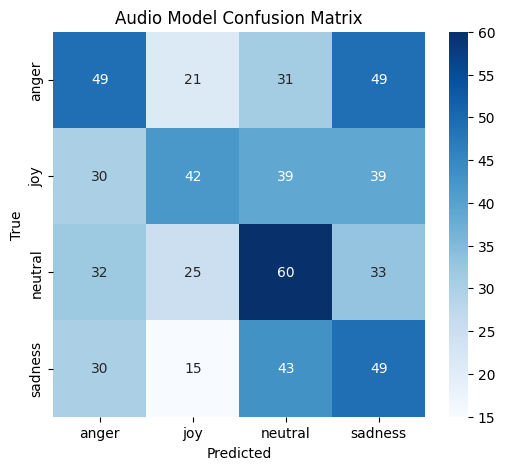

anger accuracy: 0.3267
joy accuracy: 0.2800
neutral accuracy: 0.4000
sadness accuracy: 0.3577

--------------------------------------------------

Text Model Accuracy: 0.5639

Text Model Classification Report:
               precision    recall  f1-score   support

       anger       0.57      0.53      0.55       150
         joy       0.67      0.58      0.62       150
     neutral       0.54      0.65      0.59       150
     sadness       0.49      0.49      0.49       137

    accuracy                           0.56       587
   macro avg       0.57      0.56      0.56       587
weighted avg       0.57      0.56      0.56       587



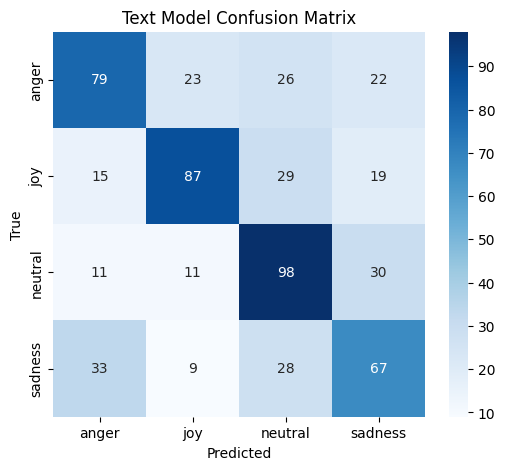

anger accuracy: 0.5267
joy accuracy: 0.5800
neutral accuracy: 0.6533
sadness accuracy: 0.4891

--------------------------------------------------

Fusion Model Accuracy: 0.5503

Fusion Model Classification Report:
               precision    recall  f1-score   support

       anger       0.52      0.55      0.54       150
         joy       0.71      0.53      0.61       150
     neutral       0.54      0.63      0.58       150
     sadness       0.47      0.47      0.47       137

    accuracy                           0.55       587
   macro avg       0.56      0.55      0.55       587
weighted avg       0.56      0.55      0.55       587



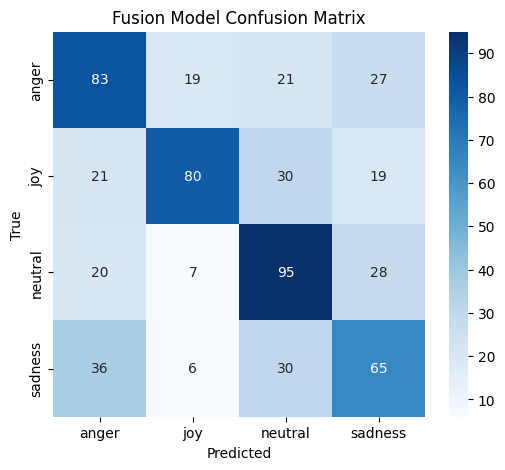

anger accuracy: 0.5533
joy accuracy: 0.5333
neutral accuracy: 0.6333
sadness accuracy: 0.4745

--------------------------------------------------



(0.5502555366269165,
 array([0, 3, 3, 2, 3, 2, 2, 1, 3, 3, 3, 2, 1, 3, 3, 0, 3, 1, 0, 2, 2, 2,
        2, 1, 3, 2, 3, 0, 2, 3, 0, 0, 0, 0, 1, 2, 1, 2, 2, 1, 2, 3, 3, 2,
        3, 1, 1, 1, 1, 2, 2, 1, 0, 2, 3, 3, 3, 2, 1, 3, 0, 0, 0, 0, 1, 0,
        0, 3, 3, 3, 1, 3, 0, 0, 3, 0, 1, 1, 0, 3, 2, 0, 2, 2, 0, 3, 2, 3,
        3, 1, 3, 2, 1, 0, 3, 1, 3, 0, 0, 2, 3, 1, 2, 3, 2, 0, 1, 2, 2, 2,
        2, 0, 3, 0, 0, 2, 1, 0, 1, 3, 3, 1, 1, 0, 0, 3, 2, 2, 2, 3, 3, 2,
        0, 1, 3, 1, 0, 2, 3, 0, 2, 2, 2, 2, 1, 2, 1, 0, 1, 3, 1, 1, 0, 0,
        0, 2, 0, 2, 1, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 1, 1, 3, 2, 2, 3,
        0, 2, 1, 0, 1, 2, 2, 0, 0, 3, 2, 0, 3, 1, 1, 3, 0, 2, 0, 2, 2, 0,
        0, 1, 3, 0, 1, 0, 1, 1, 1, 2, 2, 2, 1, 3, 2, 1, 0, 0, 3, 3, 3, 0,
        3, 3, 3, 2, 0, 0, 2, 2, 2, 1, 1, 0, 0, 0, 0, 3, 2, 0, 1, 2, 1, 1,
        3, 3, 0, 0, 2, 2, 0, 1, 3, 2, 2, 2, 2, 0, 2, 3, 3, 2, 3, 3, 0, 1,
        3, 1, 3, 2, 2, 0, 0, 2, 1, 2, 0, 0, 0, 2, 0, 0, 2, 3, 1, 0, 2, 2,
        1, 1, 0, 

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, le, title="Model", is_sequence=False):
    # If audio sequences
    if is_sequence:
        y_pred_prob = model.predict(X_test, verbose=0)
    else:
        y_pred_prob = model.predict(X_test, verbose=0)

    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    acc = accuracy_score(y_true, y_pred)
    print(f"{title} Accuracy: {acc:.4f}\n")
    print(f"{title} Classification Report:\n", classification_report(y_true, y_pred, target_names=le.classes_))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
    plt.title(f"{title} Confusion Matrix")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

    # Per-class accuracy
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    for cls, acc_cls in zip(le.classes_, per_class_acc):
        print(f"{cls} accuracy: {acc_cls:.4f}")
    print("\n" + "-"*50 + "\n")
    return acc, y_pred

# --- 1. Audio Model ---
evaluate_model(audio_model, X_audio_test_seq, y_audio_test, le, title="Audio Model", is_sequence=True)

# --- 2. Text Model ---
evaluate_model(text_model, X_text_test, y_text_test, le, title="Text Model")

# --- 3. Fusion Model ---
evaluate_model(fusion_model, [X_audio_test_seq, X_text_test], y_audio_test, le, title="Fusion Model", is_sequence=True)


In [ ]:
fusion_model.save("fusion_model.h5", include_optimizer=True, save_format="h5")

In [ ]:
fusion_model.save_weights("fusion_model.weights.h5")

# Save model config (architecture) to JSON
with open("fusion_model_config.json", "w") as f:
    f.write(fusion_model.to_json())